In [1]:
using Plots; pyplot();
using Optim
using BenchmarkTools
using Distributions

In [2]:
#one point in the state space = one column
@inline @views function kernel!(K::Matrix{Float64}, x::Matrix{Float64}, xp::Matrix{Float64}, θ::Vector{Float64})
    @inbounds s = exp(θ[1])
    @inbounds l = exp.(θ[2:length(θ)])
    
    @simd for b in 1:size(xp,2)
        @inbounds K[:, b] = s^2 * exp.(- 1/2 * sum(((x .- xp[:, b]) .^ 2) ./ (l .^ 2), 1)[1, :] )
    end
end

kernel! (generic function with 1 method)

In [3]:
function create_obj(X::Matrix{Float64}, t::Vector{Float64}) 
    n = size(X, 2)
    Ktrain = Array{Float64}(n, n)    
    L = UpperTriangular(Ktrain)
    α = Vector{Float64}(n)
    
    return function(θ)
        kernel!(Ktrain, X, X, θ)
        Ktrain = (Ktrain + 0.0001 * eye(n))
        
        L = chol(Ktrain)
        α = L \ (L' \ t)
        
        return - ( - 1/2 * t' * α - 1/2 * sum(log.(diag(L))) - n/2 * log(2 * π))
    end
end

create_obj (generic function with 1 method)

In [4]:
function learn(X::Matrix{Float64}, t::Vector{Float64}, θ::Vector{Float64})
    n = size(X, 2)
    Ktrain = Array{Float64}(n, n)
    kernel!(Ktrain, X, X, θ)
    Ktrain = (Ktrain + 0.0001 * eye(n))
    
    L = chol(Ktrain)
    α = L \ (L' \ t)

    return function (Xeval::Matrix{Float64})
        Keval = Array{Float64}(size(Xeval, 2), n)
        kernel!(Keval, Xeval, X, θ)
        return Keval * α
    end
end

function learn!(X::Matrix{Float64}, t::Vector{Float64}, θ::Vector{Float64})
    n = size(X, 2)
    Ktrain = Array{Float64}(n, n)
    kernel!(Ktrain, X, X, θ)
    Ktrain = (Ktrain + 0.0001 * eye(n))
    
    L = chol(Ktrain)
    α = L \ (L' \ t)

    return function (that::Vector{Float64}, Xeval::Matrix{Float64})
        Keval = Array{Float64}(size(Xeval, 2), n)
        kernel!(Keval, Xeval, X, θ)
        that = Keval * α
    end
end

learn! (generic function with 1 method)

2D Example
--

In [5]:
@views f(x) = abs.(0.25 - x[1, :] .^ 2 - x[2, :] .^ 2)

f (generic function with 1 method)

In [6]:
n = 100
X = rand(Uniform(), n, 2)'
X[2, :] = (1 - X[1, :]) .* X[2, :]
t = f(X);

In [7]:
θ = optimize(create_obj(X, t), [-1.2, -1.5, -1.2], LBFGS()).minimizer

3-element Array{Float64,1}:
 -0.894555
 -1.56699 
 -1.36235 

In [8]:
fhat = learn(X, t, θ)

(::#5) (generic function with 1 method)

In [9]:
N = 1000
Xtest = rand(Uniform(), N, 2)'
Xtest[2, :] = (1 - Xtest[1, :]) .* Xtest[2, :]

mean(sort(abs.( (fhat(Xtest) - f(Xtest)) ./ f(Xtest) ))[21:end-20])

0.06686684495128474


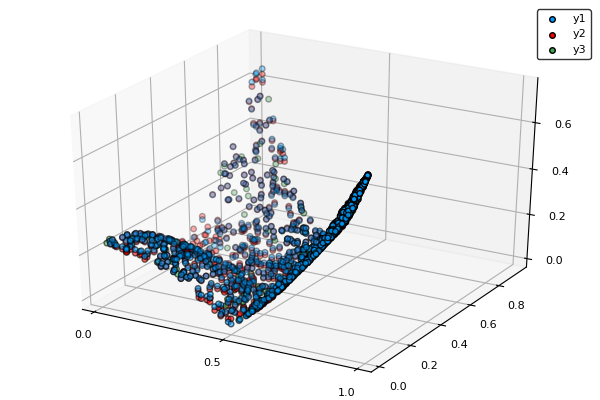

In [10]:
scatter(Xtest[1, :], Xtest[2, :], f(Xtest))
scatter!(Xtest[1, :], Xtest[2, :], fhat(Xtest), color="red")
scatter!(X[1, :], X[2, :], t)

In [11]:
@benchmark fhat(Xtest)

BenchmarkTools.Trial: 
  memory estimate:  5.42 MiB
  allocs estimate:  704
  --------------
  minimum time:     2.206 ms (0.00% GC)
  median time:      2.524 ms (0.00% GC)
  mean time:        2.731 ms (8.97% GC)
  maximum time:     5.298 ms (0.00% GC)
  --------------
  samples:          1827
  evals/sample:     1

In [12]:
fhat2 = learn!(X, t, θ)
@time that = Array{Float64}(N)
@benchmark fhat2(that, Xtest)

  0.001363 seconds (69 allocations: 12.344 KiB)


BenchmarkTools.Trial: 
  memory estimate:  5.42 MiB
  allocs estimate:  704
  --------------
  minimum time:     2.215 ms (0.00% GC)
  median time:      2.269 ms (0.00% GC)
  mean time:        2.462 ms (6.64% GC)
  maximum time:     4.392 ms (43.88% GC)
  --------------
  samples:          2027
  evals/sample:     1

1D Example
--

















In [23]:
f(x) = sin.(x)

f (generic function with 1 method)

In [24]:
n = 10
X = 2* π *rand(Uniform(), n, 1)'
t = f(X)[1, :];

In [50]:
@benchmark θ = optimize(create_obj(X, t), [0., 0], LBFGS()).minimizer

BenchmarkTools.Trial: 
  memory estimate:  6.52 MiB
  allocs estimate:  89997
  --------------
  minimum time:     3.799 ms (0.00% GC)
  median time:      3.930 ms (0.00% GC)
  mean time:        4.691 ms (14.88% GC)
  maximum time:     7.525 ms (40.23% GC)
  --------------
  samples:          1066
  evals/sample:     1

In [28]:
@benchmark fhat = learn(X, t, θ)

BenchmarkTools.Trial: 
  memory estimate:  13.42 KiB
  allocs estimate:  86
  --------------
  minimum time:     4.300 μs (0.00% GC)
  median time:      4.467 μs (0.00% GC)
  mean time:        5.162 μs (11.76% GC)
  maximum time:     163.486 μs (94.54% GC)
  --------------
  samples:          10000
  evals/sample:     7


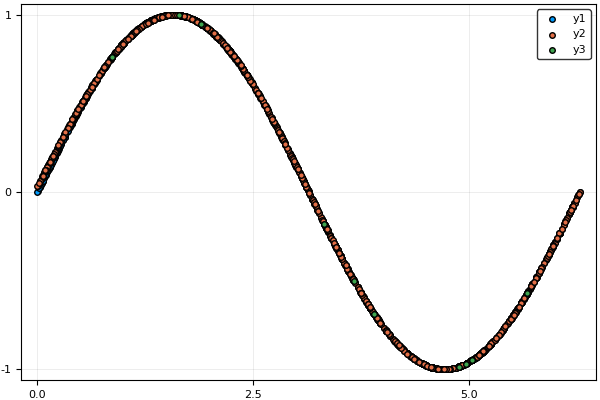

In [29]:
N = 1000
Xtest = 2 * π * rand(Uniform(), N, 1)'
scatter(Xtest[1, :], f(Xtest)[1, :])
scatter!(Xtest[1, :], fhat(Xtest))
scatter!(X[1, :], t)

Simplified Attempt
--

In [30]:
using Plots; pyplot();
using Optim
using BenchmarkTools
using Distributions
using LaTeXStrings

In [31]:
#one point = one column
@inline @views function kernel!(K::Matrix{Float64}, x::Matrix{Float64}, xp::Matrix{Float64}, θ::Vector{Float64})
    @inbounds s = exp(θ[1])
    @inbounds l = exp.(θ[2:length(θ)])
    
    @simd for a in 1:size(x,2)
        @simd for b in 1:size(xp,2)
            @inbounds K[a, b] = s^2 * exp.(- 1/2 * sum( ((x[:, a] - xp[:, b]) .^ 2) ./ (l .^ 2) ) )
        end
    end
end

kernel! (generic function with 1 method)

In [39]:
mutable struct LearnedFunction
    Xtrain::Matrix{Float64}
    Ktrain::Matrix{Float64}
    ytrain::Vector{Float64}
    n::Int64
    θ::Vector{Float64}
    L::UpperTriangular{Float64,Array{Float64,2}}
    α::Vector{Float64}
end

function LearnedFunction(Xtrain::Matrix{Float64}, ytrain::Vector{Float64}, θ::Vector{Float64})
    n = size(Xtrain, 2)
    Ktrain = Array{Float64}(n, n)
    kernel!(Ktrain, Xtrain, Xtrain, θ)
    Ktrain = (Ktrain + 0.0001 * eye(n))
    L = chol(Ktrain)
    
    return LearnedFunction(Xtrain, Ktrain, ytrain, n, θ, L, L \ (L' \ ytrain))
end

@inline function update(fhat::LearnedFunction, θnew::Vector{Float64})
    kernel!(fhat.Ktrain, fhat.Xtrain, fhat.Xtrain, θnew)
    fhat.Ktrain = (fhat.Ktrain + 0.0001 * eye(fhat.n))
    fhat.L = chol(fhat.Ktrain)
    fhat.α = fhat.L \ (fhat.L' \ fhat.ytrain)
    
    fhat.θ = θnew;
end

@inline function loglikelihood(fhat::LearnedFunction)
    return - 1/2 * fhat.ytrain' * fhat.α - 1/2 * sum(log.(diag(fhat.L))) - fhat.n/2 * log(2 * π)
end

function ml(fhat::LearnedFunction)
    obj(θtry) = begin
        update(fhat, θtry)
        return - loglikelihood(fhat)
    end
    
    result = optimize(obj, fhat.θ, LBFGS())
    
    if !(result.f_converged || result.g_converged || result.x_converged)
        warn("Optimization aborted without convergence!")
        println(result)
    end
    
    update(fhat, result.minimizer)
    
end

@inline function evaluate!(fhat::LearnedFunction, Xeval)
    Keval = Array{Float64}(size(Xeval, 2), fhat.n)
    kernel!(Keval, Xeval, fhat.Xtrain, fhat.θ)
    return Keval * fhat.α
end

@inline function evaluate!(ytrain, fhat::LearnedFunction, Xeval)
    Keval = Array{Float64}(size(Xeval, 2), fhat.n)
    kernel!(Keval, Xeval, fhat.Xtrain, fhat.θ)
    ytrain = Keval * fhat.α
end

evaluate! (generic function with 2 methods)

In [33]:
f(x) = sin.(x)

f (generic function with 1 method)

In [34]:
n = 10
X = 2* π *rand(Uniform(), n, 1)'
t = f(X)[1, :];

In [55]:
fhat = LearnedFunction(X, t, [0., 0]);

In [56]:
@time ml(fhat)

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.0,0.0]
 * Minimizer: [0.6351303252981724,0.7872453472118873]
 * Minimum: -2.653020e-01
 * Iterations: 9
 * Convergence: false
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: false
   * f(x) > f(x'): true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 39
 * Gradient Calls: 39
  0.003946 seconds (84.58 k allocations: 6.346 MiB)


2-element Array{Float64,1}:
 0.63513 
 0.787245

In [40]:
@benchmark update(fhat, [0., 0])

BenchmarkTools.Trial: 
  memory estimate:  32.38 KiB
  allocs estimate:  419
  --------------
  minimum time:     9.643 μs (0.00% GC)
  median time:      9.937 μs (0.00% GC)
  mean time:        13.738 μs (22.59% GC)
  maximum time:     2.514 ms (97.97% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [29]:
N = 1000
Xtest = 2 * π * rand(Uniform(), N, 1)'
scatter(Xtest[1, :], f(Xtest)[1, :], label = "f")
scatter!(Xtest[1, :], evaluate(fhat, Xtest), label = L"\hat{f}")
scatter!(X[1, :], t, label = "training")

LoadError: [91mUndefVarError: evaluate not defined[39m

In [54]:
@benchmark evaluate(fhat, Xtest)

BenchmarkTools.Trial: 
  memory estimate:  2.83 MiB
  allocs estimate:  40004
  --------------
  minimum time:     813.297 μs (0.00% GC)
  median time:      831.709 μs (0.00% GC)
  mean time:        1.163 ms (25.54% GC)
  maximum time:     4.766 ms (0.00% GC)
  --------------
  samples:          4289
  evals/sample:     1